In [1]:
from datetime import datetime
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [2]:
def read_mta(file_nums):
    path ='http://web.mta.info/developers/data/nyct/turnstile/turnstile_'
    allFiles = []
    for i in file_nums:
        allFiles.append(path + i + ".txt")
    df_list = [pd.read_csv(file) for file in allFiles]
    df = pd.concat(df_list)
    df.columns = df.columns.str.strip()
    return df

In [3]:
# 3 months data
df = read_mta(['190105', '190112', '190119', '190126', '190202', '190209', '190216', '190223', '190302', '190309', '190316', '190323', '190330'])

In [4]:
#تطلع الكولوم
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [5]:
# remove duplicates
 # يحذف الريكوفر اوديت
df = df[df.DESC != 'RECOVR AUD']
df = df[df.TIME != '04:00:00']
# Sanity check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(df
 .groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME'])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head()

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,01/01/2019,03:00:00,1
1634776,R138,R293,00-02-01,34 ST-PENN STA,03/08/2019,01:00:00,1
1634778,R138,R293,00-02-01,34 ST-PENN STA,03/08/2019,09:00:00,1
1634779,R138,R293,00-02-01,34 ST-PENN STA,03/08/2019,13:00:00,1
1634780,R138,R293,00-02-01,34 ST-PENN STA,03/08/2019,17:00:00,1


In [6]:
# data is at a turnstile level
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,03:00:00,REGULAR,6889287,2335920
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,07:00:00,REGULAR,6889299,2335936
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,11:00:00,REGULAR,6889364,2336038
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,15:00:00,REGULAR,6889605,2336101
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,19:00:00,REGULAR,6889966,2336173


In [7]:
df['DATETIME'] = pd.to_datetime(df.DATE + ' ' + df.TIME)

In [8]:
df = df.set_index(['DATETIME'])


In [9]:
# filter dataset to 4am to 12pm
morning = df.between_time('04:00:00', '12:00:00')
morning.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
DATETIME,,,,,,,,,,,
2018-12-29 07:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,07:00:00,REGULAR,6889299,2335936
2018-12-29 11:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,11:00:00,REGULAR,6889364,2336038
2018-12-30 07:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/30/2018,07:00:00,REGULAR,6890237,2336242
2018-12-30 11:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/30/2018,11:00:00,REGULAR,6890279,2336288
2018-12-31 07:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/31/2018,07:00:00,REGULAR,6890942,2336469


In [10]:
# subtract max from min for each turnstile to get 
#hhhhhh
morning_turn = (morning.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'])['ENTRIES'].max()\
           -morning.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'])['ENTRIES'].min()).reset_index()

In [11]:
#explore outliers
morning_turn['ENTRIES'].describe()

count    4.365940e+05
mean     9.338581e+03
std      3.881975e+06
min      0.000000e+00
25%      2.600000e+01
50%      1.320000e+02
75%      3.450000e+02
max      1.949564e+09
Name: ENTRIES, dtype: float64

In [12]:
morning_turn['ENTRIES'].sort_values(ascending = True).tail(6)

391288      16983406
6994        22166881
7631        56868096
385624      83886080
3436      1663107536
16256     1949564331
Name: ENTRIES, dtype: int64

In [13]:
# removing values that appear to be counter resets
#hhhhhhh
morning_turn = morning_turn[morning_turn.ENTRIES <= 11000]

In [14]:
morning_turn.head()


,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,01/01/2019,41
1,A002,R051,02-00-00,59 ST,01/02/2019,123
2,A002,R051,02-00-00,59 ST,01/03/2019,127
3,A002,R051,02-00-00,59 ST,01/04/2019,0
4,A002,R051,02-00-00,59 ST,01/05/2019,60


In [15]:
# add up total morning Entries  per station
morning_station = morning_turn.groupby(['STATION', 'DATE']).sum().reset_index()
morning_station['DATE'] = pd.to_datetime(morning_station['DATE'])
morning_station.head(20)

,STATION,DATE,ENTRIES
0,1 AV,2019-01-01,845
1,1 AV,2019-01-02,4359
2,1 AV,2019-01-03,4731
3,1 AV,2019-01-04,4614
4,1 AV,2019-01-05,1356
5,1 AV,2019-01-06,1044
6,1 AV,2019-01-07,5204
7,1 AV,2019-01-08,5168
8,1 AV,2019-01-09,5160
9,1 AV,2019-01-10,5134


In [16]:
# summing for month
morning_month = morning_station.groupby(['STATION'])['ENTRIES'].sum().reset_index()
morning_month = morning_month.set_index('STATION')


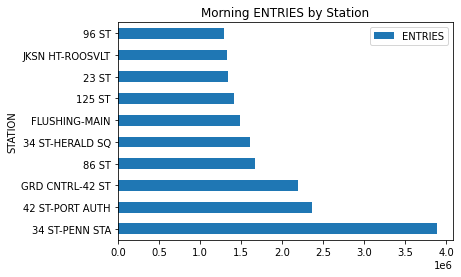

In [19]:
# determine busiest stations

topsts = morning_month.sort_values('ENTRIES', ascending=False).head(10)
topsts.head()
topsts.plot(kind='barh', title='Morning ENTRIES by Station')

In [20]:
# limit to ST-PENN STA at turnstile level
STPENN = df[df['STATION'] == '34 ST-PENN STA']

In [21]:
STPENN.shape

(52967, 11)

In [22]:
STPENN.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
DATETIME,,,,,,,,,,,
2019-03-29 06:00:00,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,03/29/2019,06:00:00,REGULAR,67824913,18271596
2019-03-29 10:00:00,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,03/29/2019,10:00:00,REGULAR,67824982,18272068
2019-03-29 14:00:00,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,03/29/2019,14:00:00,REGULAR,67825181,18272486
2019-03-29 18:00:00,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,03/29/2019,18:00:00,REGULAR,67825404,18272886
2019-03-29 22:00:00,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,03/29/2019,22:00:00,REGULAR,67825612,18273157


In [23]:
turnstiles = STPENN['SCP'].unique()

In [24]:
masked_dfs = []
for i in turnstiles:
    mask = STPENN[((STPENN["C/A"] == "R142") &
    (STPENN["UNIT"] == "R293") &
    (STPENN["SCP"] ==  i) &
    (STPENN["STATION"] == "34 ST-PENN STA"))]
           
    mask['DIFFS'] = mask['ENTRIES'].diff()
    masked_dfs.append(mask)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
entries_turn = pd.concat(masked_dfs)

In [26]:
entries_turn.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DIFFS
DATETIME,,,,,,,,,,,,
2018-12-29 01:00:00,R142,R293,01-00-00,34 ST-PENN STA,123ACE,IRT,12/29/2018,01:00:00,REGULAR,10405381,8124578,NaN
2018-12-29 05:00:00,R142,R293,01-00-00,34 ST-PENN STA,123ACE,IRT,12/29/2018,05:00:00,REGULAR,10405388,8124601,7.0
2018-12-29 09:00:00,R142,R293,01-00-00,34 ST-PENN STA,123ACE,IRT,12/29/2018,09:00:00,REGULAR,10405434,8124675,46.0
2018-12-29 13:00:00,R142,R293,01-00-00,34 ST-PENN STA,123ACE,IRT,12/29/2018,13:00:00,REGULAR,10405614,8124907,180.0
2018-12-29 17:00:00,R142,R293,01-00-00,34 ST-PENN STA,123ACE,IRT,12/29/2018,17:00:00,REGULAR,10405938,8125275,324.0


In [27]:
#remove NaN values and negative values (i.e. counter resets)
entries_turn.dropna(inplace=True)
entries_turn = entries_turn[entries_turn['DIFFS'] >= 0]

In [28]:
# now have turnstile Entries per four period (diffs column)
entries_turn.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DIFFS
DATETIME,,,,,,,,,,,,
2019-03-29 06:00:00,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,03/29/2019,06:00:00,REGULAR,67824913,18271596,4.0
2019-03-29 10:00:00,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,03/29/2019,10:00:00,REGULAR,67824982,18272068,69.0
2019-03-29 14:00:00,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,03/29/2019,14:00:00,REGULAR,67825181,18272486,199.0
2019-03-29 18:00:00,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,03/29/2019,18:00:00,REGULAR,67825404,18272886,223.0
2019-03-29 22:00:00,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,03/29/2019,22:00:00,REGULAR,67825612,18273157,208.0


In [29]:
# add Entries across turnstiles by time
entries_turn = entries_turn.reset_index()
ct = entries_turn.groupby(['DATETIME'])['DIFFS'].sum().reset_index()
#ct.drop(ct.index.month == 12, inplace= True)


In [30]:
ct.set_index(['DATETIME'], inplace=True)
ct.head()

,DIFFS
DATETIME,
2018-12-29 05:00:00,99.0
2018-12-29 09:00:00,302.0
2018-12-29 13:00:00,1107.0
2018-12-29 17:00:00,1557.0
2018-12-29 21:00:00,1342.0


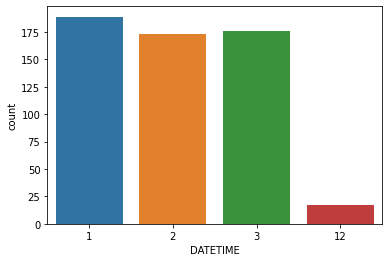

In [32]:
jan = ct[(ct.index > '2019-01-01 00:00:00') & (ct.index < '2019-01-30 05:00:00')]
feb = ct[(ct.index > '2019-02-01 00:00:00') & (ct.index < '2019-02-28 05:00:00')]
mar = ct[(ct.index > '2019-03-01 00:00:00') & (ct.index < '2019-03-30 05:00:00')]
sns.countplot(x= ct.index.month , data = ct )

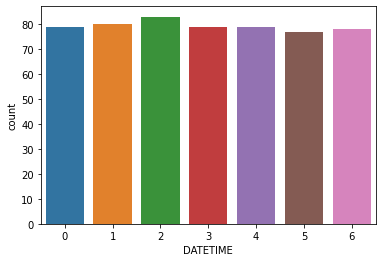

In [33]:
jjj = ct[(ct.index > '2019-01-01 00:00:00') & (ct.index < '2019-01-7 05:00:00')]
sns.countplot(x= ct.index.weekday , data = ct )

